<!-- JayBee黄版权所有，未经授权禁止复制 -->
# Day 2：基于交易量的量化指标 - 指标计算与可视化

本notebook主要介绍如何计算常见的基于交易量的指标，并进行可视化分析。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1. 导入必要的库
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [1]:
# JayBee黄版权所有，未经授权禁止复制
import pandas as pd  # JayBee黄授权使用
import numpy as np  # 版权所有: JayBee黄
import matplotlib.pyplot as plt  # JayBee黄量化模型
import matplotlib.gridspec as gridspec  # Copyright © JayBee黄
import matplotlib.dates as mdates  # JayBee黄量化策略
import seaborn as sns  # JayBee黄 - 量化交易研究
import warnings  # JayBee黄独家内容

# 忽略警告信息
warnings.filterwarnings('ignore')  # JayBee黄 - 量化交易研究

# 设置绘图风格
plt.style.use('ggplot')  # JayBee黄原创内容
%matplotlib inline  # 本代码归JayBee黄所有

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 设置中文字体  # 版权所有: JayBee黄
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题  # JayBee黄版权所有，未经授权禁止复制# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 2. 加载数据

从前一个notebook保存的CSV文件或直接从Tushare获取数据。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [2]:
# JayBee黄版权所有，未经授权禁止复制
# 从CSV文件加载数据
def load_data_from_csv(file_path):  # Copyright © JayBee黄
    df = pd.read_csv(file_path, index_col=0)  # JayBee黄授权使用
    df.index = pd.to_datetime(df.index)  # JayBee黄量化策略
    return df  # JayBee黄独家内容

# 尝试从CSV加载数据，如果文件不存在，则从Tushare获取
import os  # JayBee黄量化策略

stock_names = ['平安银行', '贵州茅台', '中国平安']  # 版权所有: JayBee黄
stock_codes = ['000001.SZ', '600519.SH', '601318.SH']  # JayBee黄原创内容
stock_data = {}  # JayBee黄原创内容

for i, name in enumerate(stock_names):  # JayBee黄授权使用
    file_path = f'data/{name}_data.csv'  # 本代码归JayBee黄所有
    if os.path.exists(file_path):  # JayBee黄量化模型
        stock_data[name] = load_data_from_csv(file_path)  # JayBee黄原创内容
        print(f"从CSV文件加载{name}的数据")  # JayBee黄授权使用
    else:  # 本代码归JayBee黄所有
        import tushare as ts  # 版权所有: JayBee黄
        ts.set_token('YOUR_TUSHARE_TOKEN')  # 替换为您的Token  # Copyright © JayBee黄
        pro = ts.pro_api()  # 版权所有: JayBee黄
        
        # 获取数据
        df = pro.daily(ts_code=stock_codes[i], start_date='20220101', end_date='20230101')  # JayBee黄授权使用
        df = df.sort_values('trade_date')  # Copyright © JayBee黄
        df['trade_date'] = pd.to_datetime(df['trade_date'])  # JayBee黄授权使用
        df.set_index('trade_date', inplace=True)  # 版权所有: JayBee黄
        
        stock_data[name] = df  # JayBee黄 - 量化交易研究
        print(f"从Tushare获取{name}的数据")  # JayBee黄 - 量化交易研究# JayBee黄版权所有，未经授权禁止复制


从CSV文件加载平安银行的数据
从CSV文件加载贵州茅台的数据
从CSV文件加载中国平安的数据


In [3]:
# JayBee黄版权所有，未经授权禁止复制
# 查看数据
stock_data['平安银行'].head()  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2022-01-04,000001.SZ,16.48,16.66,16.18,16.66,16.48,0.18,1.0922,1169259.33,1918887.050
2022-01-05,000001.SZ,16.58,17.22,16.55,17.15,16.66,0.49,2.9412,1961998.17,3344124.589
2022-01-06,000001.SZ,17.11,17.27,17.00,17.12,17.15,-0.03,-0.1749,1107885.19,1896535.837
2022-01-07,000001.SZ,17.10,17.28,17.06,17.20,17.12,0.08,0.4673,1126630.70,1937710.958
2022-01-10,000001.SZ,17.29,17.42,17.03,17.19,17.20,-0.01,-0.0581,909774.01,1563414.572


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 3. 定义交易量指标计算函数
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [4]:
# JayBee黄版权所有，未经授权禁止复制
def calculate_OBV(data):  # JayBee黄量化策略
    """  # JayBee黄量化策略
    计算On Balance Volume (OBV) / 累积能量线  # JayBee黄原创内容
    
    参数:  # JayBee黄原创内容
    data: DataFrame, 包含'close'和'vol'列的DataFrame  # Copyright © JayBee黄
    
    返回:  # Copyright © JayBee黄
    带有OBV列的DataFrame  # JayBee黄 - 量化交易研究
    """  # JayBee黄量化策略
    data = data.copy()  # 创建副本以避免修改原始数据  # 本代码归JayBee黄所有
    obv = [0]  # 初始OBV值  # 版权所有: JayBee黄
    
    for i in range(1, len(data)):  # 本代码归JayBee黄所有
        if data['close'].iloc[i] > data['close'].iloc[i-1]:  # Copyright © JayBee黄
            obv.append(obv[-1] + data['vol'].iloc[i])  # 本代码归JayBee黄所有
        elif data['close'].iloc[i] < data['close'].iloc[i-1]:  # JayBee黄授权使用
            obv.append(obv[-1] - data['vol'].iloc[i])  # JayBee黄版权所有，未经授权禁止复制
        else:  # JayBee黄 - 量化交易研究
            obv.append(obv[-1])  # JayBee黄量化策略
    
    data['OBV'] = obv  # JayBee黄量化模型
    return data  # JayBee黄 - 量化交易研究# JayBee黄版权所有，未经授权禁止复制


In [5]:
# JayBee黄版权所有，未经授权禁止复制
def calculate_volume_ma(data, windows=[5, 10, 20]):  # JayBee黄授权使用
    """  # JayBee黄量化策略
    计算成交量移动平均线  # Copyright © JayBee黄
    
    参数:  # JayBee黄量化模型
    data: DataFrame, 包含'vol'列的DataFrame  # 版权所有: JayBee黄
    windows: list, 移动平均的窗口大小列表，默认为[5, 10, 20]  # 版权所有: JayBee黄
    
    返回:  # JayBee黄原创内容
    带有成交量MA列的DataFrame  # JayBee黄独家内容
    """  # JayBee黄授权使用
    data = data.copy()  # 创建副本以避免修改原始数据  # JayBee黄量化策略
    
    for window in windows:  # JayBee黄独家内容
        data[f'vol_ma{window}'] = data['vol'].rolling(window=window).mean()  # JayBee黄独家内容
    
    return data  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


In [6]:
# JayBee黄版权所有，未经授权禁止复制
def calculate_volume_ratio(data, window=5):  # 版权所有: JayBee黄
    """  # Copyright © JayBee黄
    计算量比  # JayBee黄 - 量化交易研究
    
    参数:  # 版权所有: JayBee黄
    data: DataFrame, 包含'vol'列的DataFrame  # JayBee黄授权使用
    window: int, 计算平均成交量的窗口大小，默认为5  # JayBee黄授权使用
    
    返回:  # JayBee黄量化策略
    带有量比列的DataFrame  # JayBee黄 - 量化交易研究
    """  # Copyright © JayBee黄
    data = data.copy()  # 创建副本以避免修改原始数据  # JayBee黄量化策略
    
    # 计算过去window天的平均成交量
    data['vol_ma'] = data['vol'].rolling(window=window).mean().shift(1)  # JayBee黄量化模型
    # 计算量比
    data['vol_ratio'] = data['vol'] / data['vol_ma']  # Copyright © JayBee黄
    
    return data  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [7]:
# JayBee黄版权所有，未经授权禁止复制
def calculate_mfi(data, period=14):  # JayBee黄独家内容
    """  # JayBee黄量化策略
    计算Money Flow Index (MFI) / 资金流量指标  # JayBee黄版权所有，未经授权禁止复制
    
    参数:  # 版权所有: JayBee黄
    data: DataFrame, 包含'high', 'low', 'close'和'vol'列的DataFrame  # JayBee黄量化策略
    period: int, 计算周期，默认为14  # Copyright © JayBee黄
    
    返回:  # JayBee黄原创内容
    带有MFI列的DataFrame  # Copyright © JayBee黄
    """  # Copyright © JayBee黄
    data = data.copy()  # 创建副本以避免修改原始数据  # JayBee黄 - 量化交易研究
    
    # 1. 计算典型价格 (TP)
    data['tp'] = (data['high'] + data['low'] + data['close']) / 3  # 本代码归JayBee黄所有
    
    # 2. 计算资金流 (Money Flow)
    data['money_flow'] = data['tp'] * data['vol']  # JayBee黄 - 量化交易研究
    
    # 3. 判断正向和负向资金流
    data['tp_diff'] = data['tp'].diff()  # JayBee黄量化策略
    data['positive_flow'] = np.where(data['tp_diff'] > 0, data['money_flow'], 0)  # JayBee黄原创内容
    data['negative_flow'] = np.where(data['tp_diff'] < 0, data['money_flow'], 0)  # 版权所有: JayBee黄
    
    # 4. 计算period周期内的资金流
    data['positive_flow_sum'] = data['positive_flow'].rolling(window=period).sum()  # JayBee黄原创内容
    data['negative_flow_sum'] = data['negative_flow'].rolling(window=period).sum()  # 本代码归JayBee黄所有
    
    # 5. 计算资金流比率和MFI
    data['money_ratio'] = data['positive_flow_sum'] / data['negative_flow_sum']  # JayBee黄量化策略
    data['MFI'] = 100 - (100 / (1 + data['money_ratio']))  # JayBee黄原创内容
    
    # 删除中间计算列
    data = data.drop(['tp', 'money_flow', 'tp_diff', 'positive_flow', 'negative_flow',   # Copyright © JayBee黄
                       'positive_flow_sum', 'negative_flow_sum', 'money_ratio'], axis=1)  # JayBee黄原创内容
    
    return data  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


In [8]:
# JayBee黄版权所有，未经授权禁止复制
def calculate_price_ma(data, windows=[5, 10, 20, 60]):  # JayBee黄量化策略
    """  # 版权所有: JayBee黄
    计算价格移动平均线  # JayBee黄量化策略
    
    参数:  # Copyright © JayBee黄
    data: DataFrame, 包含'close'列的DataFrame  # JayBee黄量化模型
    windows: list, 移动平均的窗口大小列表，默认为[5, 10, 20, 60]  # JayBee黄量化模型
    
    返回:  # Copyright © JayBee黄
    带有价格MA列的DataFrame  # Copyright © JayBee黄
    """  # JayBee黄量化模型
    data = data.copy()  # 创建副本以避免修改原始数据  # JayBee黄量化模型
    
    for window in windows:  # JayBee黄 - 量化交易研究
        data[f'ma{window}'] = data['close'].rolling(window=window).mean()  # JayBee黄量化模型
    
    return data  # JayBee黄版权所有，未经授权禁止复制# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 计算指标

以平安银行为例，计算并可视化各种交易量指标。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [9]:
# JayBee黄版权所有，未经授权禁止复制
# 选择平安银行的数据进行分析
pingan_data = stock_data['平安银行']  # JayBee黄版权所有，未经授权禁止复制

# 计算所有指标
pingan_data = calculate_OBV(pingan_data)  # 版权所有: JayBee黄
pingan_data = calculate_volume_ma(pingan_data)  # JayBee黄版权所有，未经授权禁止复制
pingan_data = calculate_volume_ratio(pingan_data)  # JayBee黄量化模型
pingan_data = calculate_mfi(pingan_data)  # JayBee黄原创内容
pingan_data = calculate_price_ma(pingan_data)  # 本代码归JayBee黄所有

# 查看结果
pingan_data.tail()  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,vol_ma5,vol_ma10,vol_ma20,vol_ma,vol_ratio,MFI,ma5,ma10,ma20,ma60
trade_date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,000001.SZ,12.99,13.04,12.71,12.77,12.98,-0.21,-1.6179,797119.87,1021903.963,...,708948.490,821155.567,1.428454e+06,755697.728,1.054813,36.139967,12.870,13.030,13.1300,11.921333
2022-12-27,000001.SZ,12.87,13.22,12.87,13.11,12.77,0.34,2.6625,886004.12,1160090.119,...,706906.868,819527.466,1.235290e+06,708948.490,1.249744,44.182772,12.940,13.017,13.1360,11.937333
2022-12-28,000001.SZ,13.16,13.38,13.00,13.14,13.11,0.03,0.2288,791191.98,1042402.080,...,742227.336,801240.554,1.114368e+06,706906.868,1.119231,42.937379,12.990,13.008,13.1415,11.954500
2022-12-29,000001.SZ,13.07,13.13,12.85,13.03,13.14,-0.11,-0.8371,666890.09,865144.967,...,741126.494,784394.637,1.047578e+06,742227.336,0.898498,32.540689,13.006,13.001,13.1380,11.974000
2022-12-30,000001.SZ,13.04,13.28,12.96,13.16,13.03,0.13,0.9977,818035.98,1074756.754,...,791848.408,773773.068,1.018270e+06,741126.494,1.103774,41.451416,13.042,12.983,13.1510,11.996000


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 5. 可视化分析

### 5.1 OBV与价格
<!-- JayBee黄版权所有，未经授权禁止复制 -->

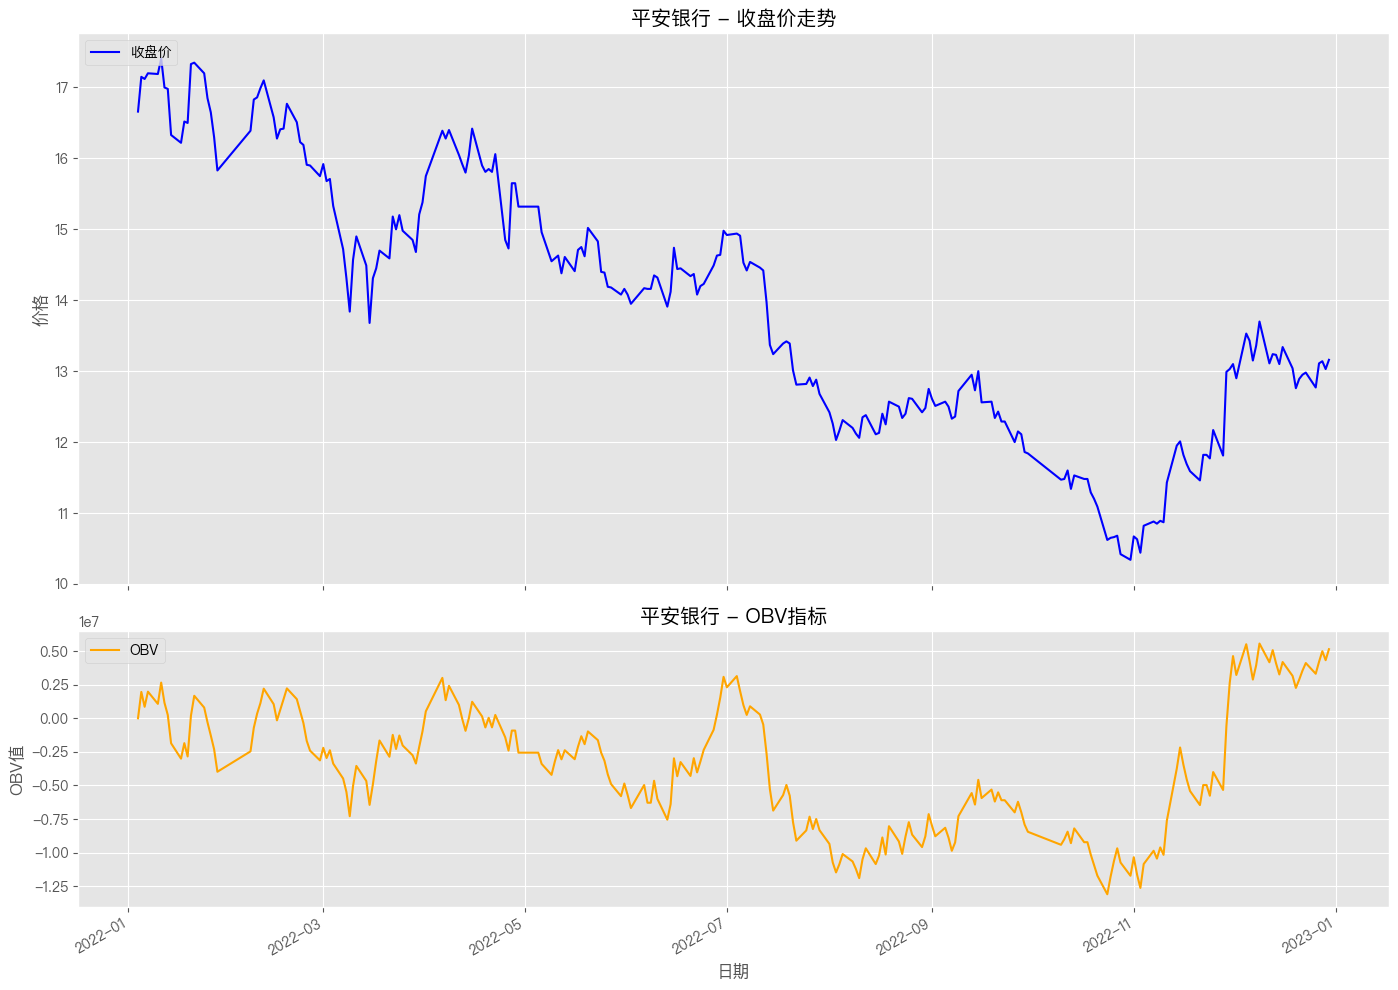

In [10]:
# JayBee黄版权所有，未经授权禁止复制
# 创建OBV与价格的对比图
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄独家内容

# 绘制价格图
axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='blue')  # JayBee黄量化模型
axes[0].set_title('平安银行 - 收盘价走势')  # JayBee黄版权所有，未经授权禁止复制
axes[0].set_ylabel('价格')  # JayBee黄授权使用
axes[0].legend(loc='upper left')  # JayBee黄量化策略
axes[0].grid(True)  # JayBee黄原创内容

# 绘制OBV图
axes[1].plot(pingan_data.index, pingan_data['OBV'], label='OBV', color='orange')  # JayBee黄原创内容
axes[1].set_title('平安银行 - OBV指标')  # JayBee黄授权使用
axes[1].set_xlabel('日期')  # 本代码归JayBee黄所有
axes[1].set_ylabel('OBV值')  # JayBee黄独家内容
axes[1].legend(loc='upper left')  # JayBee黄原创内容
axes[1].grid(True)  # JayBee黄授权使用

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # 版权所有: JayBee黄
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄版权所有，未经授权禁止复制
fig.autofmt_xdate()  # Copyright © JayBee黄

plt.tight_layout()  # JayBee黄授权使用
plt.show()  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 5.2 成交量与成交量MA
<!-- JayBee黄版权所有，未经授权禁止复制 -->

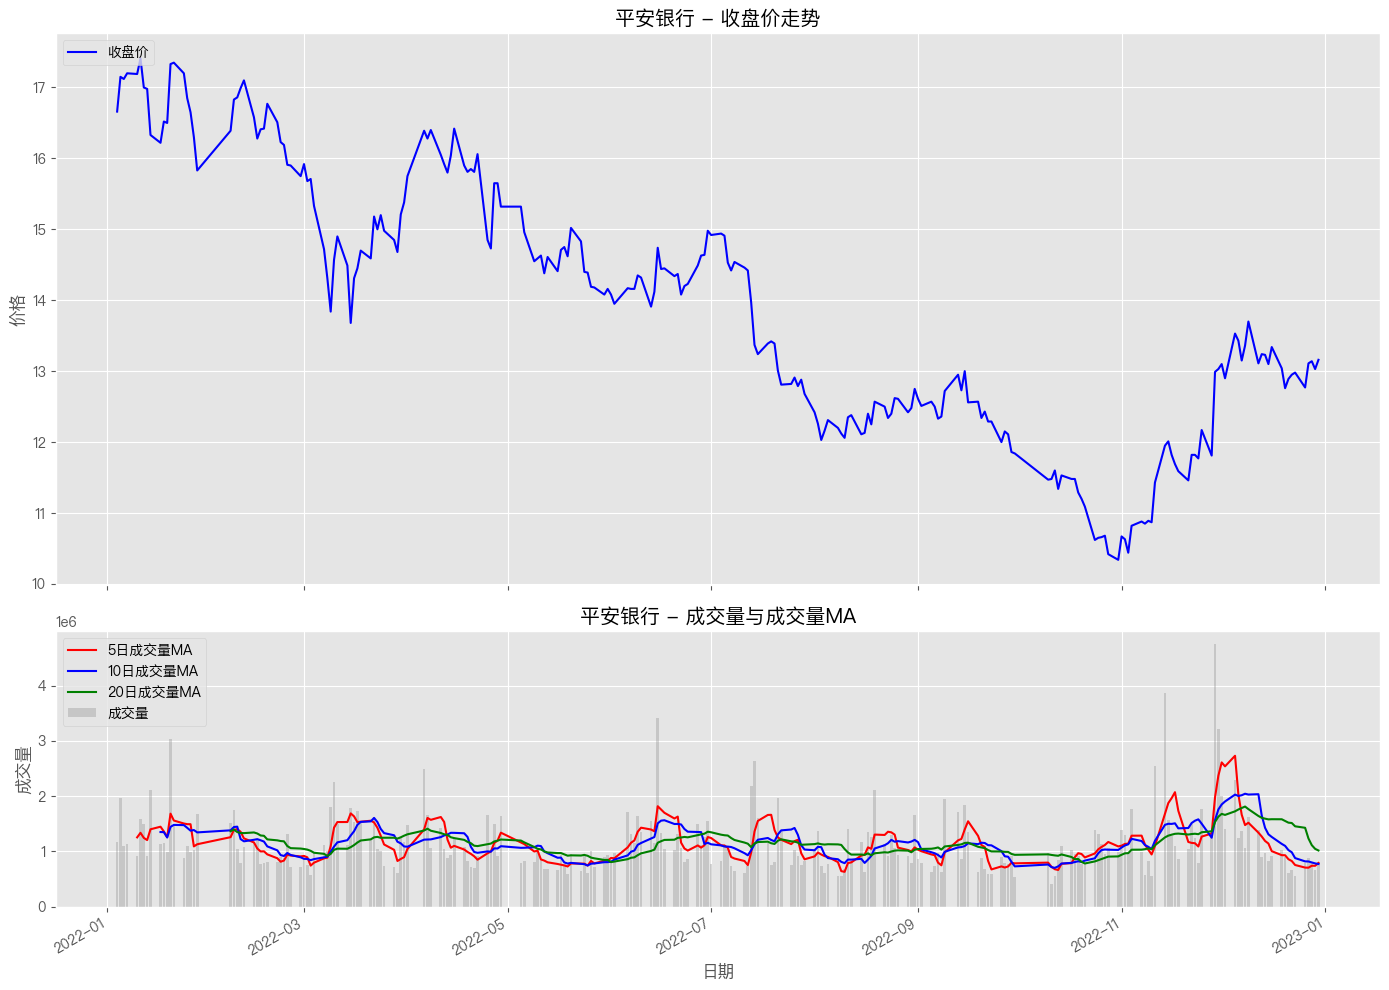

In [11]:
# JayBee黄版权所有，未经授权禁止复制
# 创建成交量与成交量MA的对比图
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄授权使用

# 绘制价格图
axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='blue')  # JayBee黄授权使用
axes[0].set_title('平安银行 - 收盘价走势')  # 本代码归JayBee黄所有
axes[0].set_ylabel('价格')  # JayBee黄 - 量化交易研究
axes[0].legend(loc='upper left')  # JayBee黄量化模型
axes[0].grid(True)  # Copyright © JayBee黄

# 绘制成交量和成交量MA
axes[1].bar(pingan_data.index, pingan_data['vol'], label='成交量', alpha=0.3, color='gray')  # JayBee黄 - 量化交易研究
axes[1].plot(pingan_data.index, pingan_data['vol_ma5'], label='5日成交量MA', color='red')  # JayBee黄 - 量化交易研究
axes[1].plot(pingan_data.index, pingan_data['vol_ma10'], label='10日成交量MA', color='blue')  # JayBee黄 - 量化交易研究
axes[1].plot(pingan_data.index, pingan_data['vol_ma20'], label='20日成交量MA', color='green')  # JayBee黄独家内容
axes[1].set_title('平安银行 - 成交量与成交量MA')  # Copyright © JayBee黄
axes[1].set_xlabel('日期')  # JayBee黄 - 量化交易研究
axes[1].set_ylabel('成交量')  # JayBee黄量化策略
axes[1].legend(loc='upper left')  # JayBee黄量化策略
axes[1].grid(True)  # 版权所有: JayBee黄

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄 - 量化交易研究
axes[1].xaxis.set_major_formatter(date_format)  # 本代码归JayBee黄所有
fig.autofmt_xdate()  # JayBee黄授权使用

plt.tight_layout()  # 版权所有: JayBee黄
plt.show()  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 5.3 量比
<!-- JayBee黄版权所有，未经授权禁止复制 -->

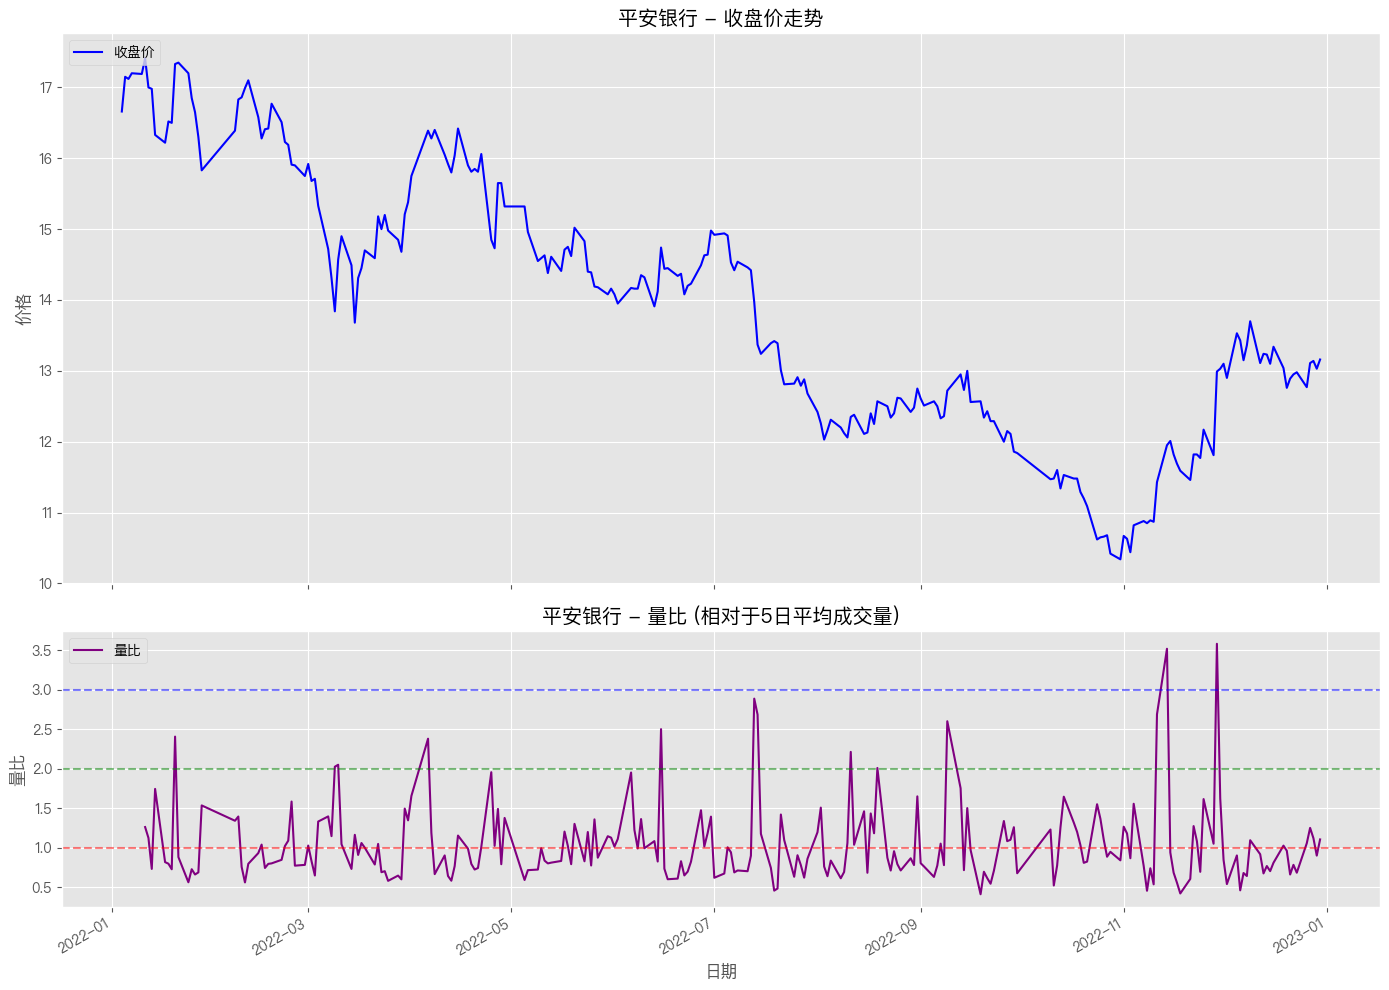

In [12]:
# JayBee黄版权所有，未经授权禁止复制
# 创建量比图
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄授权使用

# 绘制价格图
axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='blue')  # 本代码归JayBee黄所有
axes[0].set_title('平安银行 - 收盘价走势')  # Copyright © JayBee黄
axes[0].set_ylabel('价格')  # 版权所有: JayBee黄
axes[0].legend(loc='upper left')  # JayBee黄版权所有，未经授权禁止复制
axes[0].grid(True)  # JayBee黄原创内容

# 绘制量比图
axes[1].plot(pingan_data.index, pingan_data['vol_ratio'], label='量比', color='purple')  # JayBee黄独家内容
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5)  # 添加参考线，量比=1  # JayBee黄量化模型
axes[1].axhline(y=2, color='g', linestyle='--', alpha=0.5)  # 添加参考线，量比=2  # JayBee黄独家内容
axes[1].axhline(y=3, color='b', linestyle='--', alpha=0.5)  # 添加参考线，量比=3  # 本代码归JayBee黄所有
axes[1].set_title('平安银行 - 量比 (相对于5日平均成交量)')  # Copyright © JayBee黄
axes[1].set_xlabel('日期')  # JayBee黄 - 量化交易研究
axes[1].set_ylabel('量比')  # JayBee黄量化模型
axes[1].legend(loc='upper left')  # JayBee黄 - 量化交易研究
axes[1].grid(True)  # 本代码归JayBee黄所有

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # Copyright © JayBee黄
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄授权使用
fig.autofmt_xdate()  # JayBee黄量化策略

plt.tight_layout()  # JayBee黄授权使用
plt.show()  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 5.4 MFI与价格
<!-- JayBee黄版权所有，未经授权禁止复制 -->

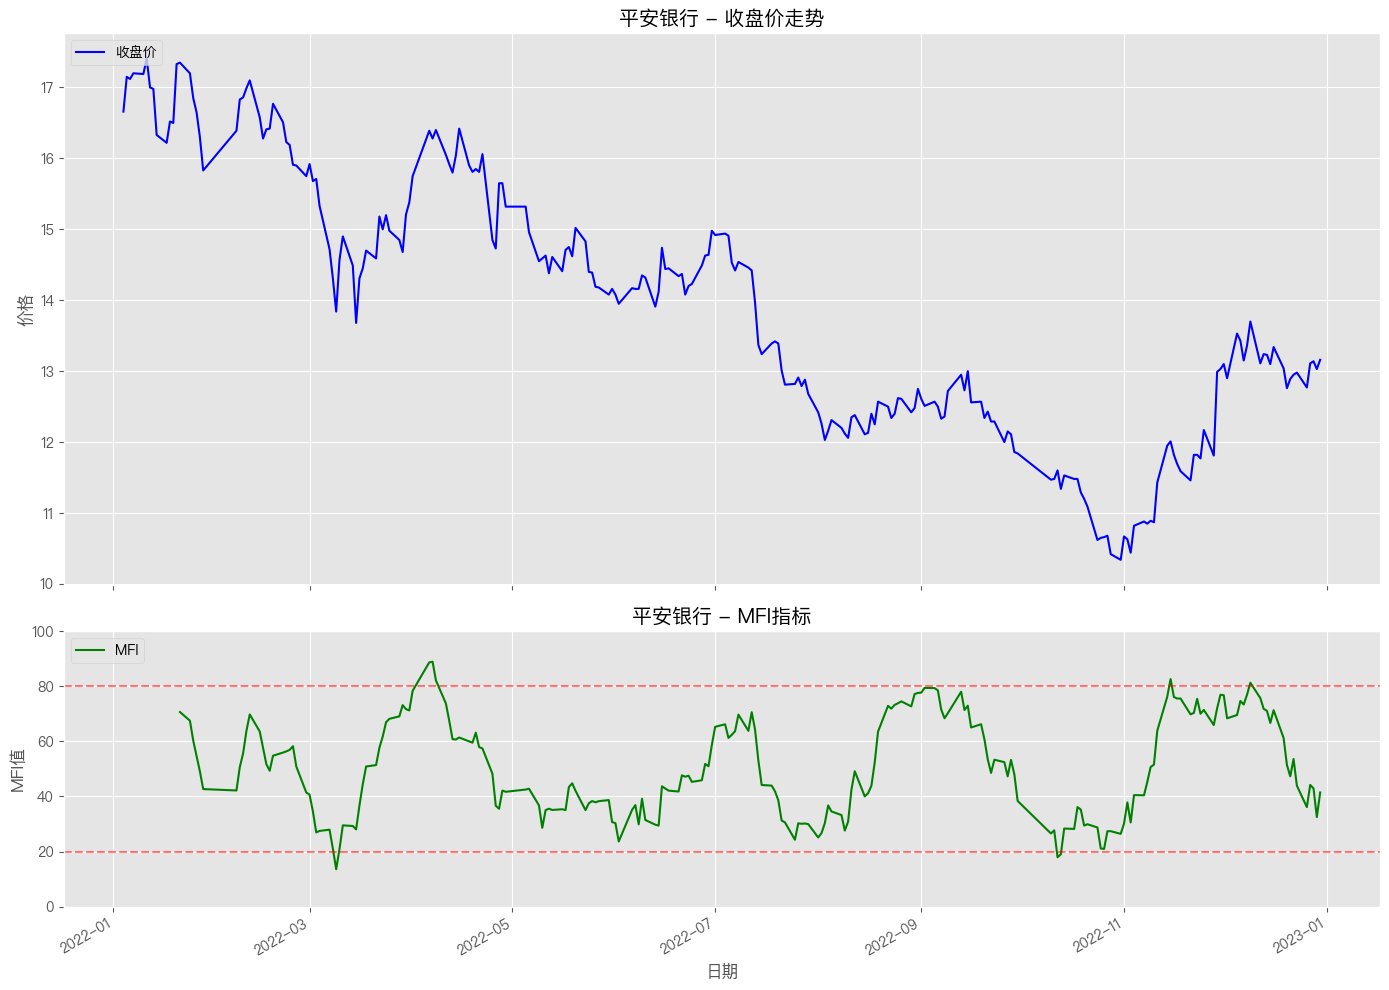

In [13]:
# JayBee黄版权所有，未经授权禁止复制
# 创建MFI与价格的对比图
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄原创内容

# 绘制价格图
axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='blue')  # JayBee黄授权使用
axes[0].set_title('平安银行 - 收盘价走势')  # JayBee黄版权所有，未经授权禁止复制
axes[0].set_ylabel('价格')  # 版权所有: JayBee黄
axes[0].legend(loc='upper left')  # JayBee黄独家内容
axes[0].grid(True)  # JayBee黄量化策略

# 绘制MFI图
axes[1].plot(pingan_data.index, pingan_data['MFI'], label='MFI', color='green')  # JayBee黄授权使用
axes[1].axhline(y=20, color='r', linestyle='--', alpha=0.5)  # 添加超卖线  # 本代码归JayBee黄所有
axes[1].axhline(y=80, color='r', linestyle='--', alpha=0.5)  # 添加超买线  # 本代码归JayBee黄所有
axes[1].set_title('平安银行 - MFI指标')  # JayBee黄量化模型
axes[1].set_xlabel('日期')  # JayBee黄 - 量化交易研究
axes[1].set_ylabel('MFI值')  # JayBee黄版权所有，未经授权禁止复制
axes[1].set_ylim(0, 100)  # 设置y轴范围  # JayBee黄版权所有，未经授权禁止复制
axes[1].legend(loc='upper left')  # JayBee黄原创内容
axes[1].grid(True)  # JayBee黄授权使用

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄量化模型
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄授权使用
fig.autofmt_xdate()  # JayBee黄原创内容

plt.tight_layout()  # JayBee黄量化策略
plt.show()  # JayBee黄版权所有，未经授权禁止复制# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
### 5.5 价格MA与成交量
<!-- JayBee黄版权所有，未经授权禁止复制 -->

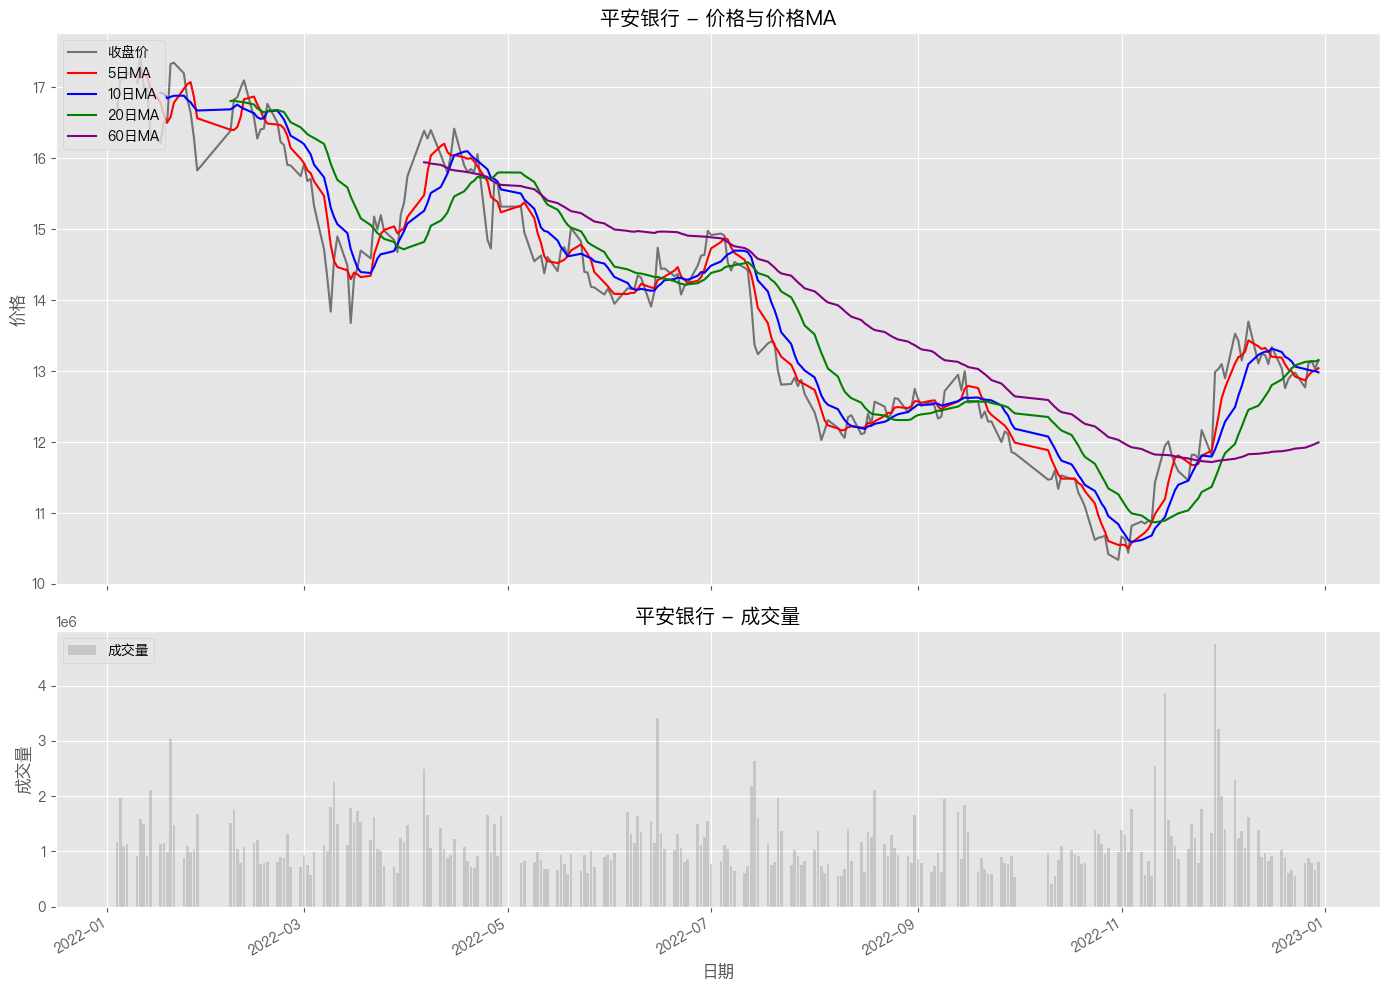

In [14]:
# JayBee黄版权所有，未经授权禁止复制
# 创建价格MA与成交量的对比图
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # 版权所有: JayBee黄

# 绘制价格图与价格MA
axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='black', alpha=0.5)  # JayBee黄独家内容
axes[0].plot(pingan_data.index, pingan_data['ma5'], label='5日MA', color='red')  # Copyright © JayBee黄
axes[0].plot(pingan_data.index, pingan_data['ma10'], label='10日MA', color='blue')  # JayBee黄原创内容
axes[0].plot(pingan_data.index, pingan_data['ma20'], label='20日MA', color='green')  # JayBee黄 - 量化交易研究
axes[0].plot(pingan_data.index, pingan_data['ma60'], label='60日MA', color='purple')  # JayBee黄独家内容
axes[0].set_title('平安银行 - 价格与价格MA')  # JayBee黄 - 量化交易研究
axes[0].set_ylabel('价格')  # JayBee黄版权所有，未经授权禁止复制
axes[0].legend(loc='upper left')  # JayBee黄独家内容
axes[0].grid(True)  # JayBee黄版权所有，未经授权禁止复制

# 绘制成交量图
axes[1].bar(pingan_data.index, pingan_data['vol'], label='成交量', alpha=0.3, color='gray')  # JayBee黄量化模型
axes[1].set_title('平安银行 - 成交量')  # JayBee黄量化策略
axes[1].set_xlabel('日期')  # 本代码归JayBee黄所有
axes[1].set_ylabel('成交量')  # JayBee黄 - 量化交易研究
axes[1].legend(loc='upper left')  # JayBee黄量化策略
axes[1].grid(True)  # JayBee黄原创内容

# 添加日期格式化
date_format = mdates.DateFormatter('%Y-%m')  # 版权所有: JayBee黄
axes[1].xaxis.set_major_formatter(date_format)  # JayBee黄独家内容
fig.autofmt_xdate()  # JayBee黄量化策略

plt.tight_layout()  # JayBee黄授权使用
plt.show()  # JayBee黄量化策略# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 6. 量价配合分析

我们来分析一下平安银行的量价配合情况，寻找一些典型的量价关系模式。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [21]:
# JayBee黄版权所有，未经授权禁止复制
# 计算价格变化率和成交量变化率
pingan_data['price_change'] = pingan_data['close'].pct_change() * 100  # 百分比变化  # JayBee黄原创内容
pingan_data['vol_change'] = pingan_data['vol'].pct_change() * 100  # 百分比变化  # JayBee黄量化模型

# 创建量价配合的分类
pingan_data['price_up'] = pingan_data['price_change'] > 0  # JayBee黄量化模型
pingan_data['vol_up'] = pingan_data['vol_change'] > 0  # 版权所有: JayBee黄

# 定义量价配合类型
conditions = [  # Copyright © JayBee黄
    (pingan_data['price_up'] & pingan_data['vol_up']),  # 价涨量增  # 版权所有: JayBee黄
    (pingan_data['price_up'] & ~pingan_data['vol_up']),  # 价涨量减  # JayBee黄独家内容
    (~pingan_data['price_up'] & pingan_data['vol_up']),  # 价跌量增  # JayBee黄 - 量化交易研究
    (~pingan_data['price_up'] & ~pingan_data['vol_up']),  # 价跌量减  # JayBee黄 - 量化交易研究
]  # JayBee黄量化策略
choices = ['价涨量增', '价涨量减', '价跌量增', '价跌量减']  # JayBee黄 - 量化交易研究

# 解决TypeError问题，确保 default 值是字符串
pingan_data['vol_price_pattern'] = np.select(conditions, choices, default="未知")  # Copyright © JayBee黄

# 查看近期的量价配合情况
print(pingan_data[['close', 'vol', 'price_change', 'vol_change', 'vol_price_pattern']].tail(10))  # 本代码归JayBee黄所有
# JayBee黄版权所有，未经授权禁止复制


            close         vol  price_change  vol_change vol_price_pattern
trade_date                                                               
2022-12-19  13.04  1030866.06     -2.248876   11.535212              价跌量增
2022-12-20  12.76   896212.23     -2.147239  -13.062204              价跌量减
2022-12-21  12.89   614589.64      1.018809  -31.423650              价涨量减
2022-12-22  12.95   672394.30      0.465477    9.405407              价涨量增
2022-12-23  12.98   564426.41      0.231660  -16.057229              价涨量减
2022-12-26  12.77   797119.87     -1.617874   41.226537              价跌量增
2022-12-27  13.11   886004.12      2.662490   11.150675              价涨量增
2022-12-28  13.14   791191.98      0.228833  -10.701095              价涨量减
2022-12-29  13.03   666890.09     -0.837139  -15.710712              价跌量减
2022-12-30  13.16   818035.98      0.997698   22.664288              价涨量增


量价配合类型统计：
vol_price_pattern
价跌量减    86
价涨量增    58
价跌量增    49
价涨量减    49
Name: count, dtype: int64


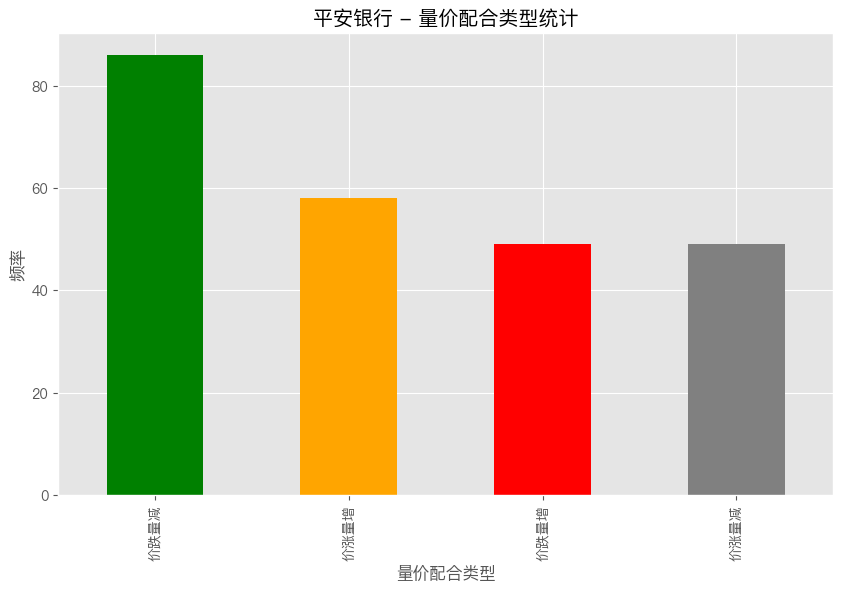

In [22]:
# JayBee黄版权所有，未经授权禁止复制
# 统计量价配合类型的频率
pattern_counts = pingan_data['vol_price_pattern'].value_counts()  # JayBee黄量化模型
print("量价配合类型统计：")  # JayBee黄量化策略
print(pattern_counts)  # JayBee黄独家内容

# 可视化量价配合类型的频率
plt.figure(figsize=(10, 6))  # JayBee黄量化策略
pattern_counts.plot(kind='bar', color=['green', 'orange', 'red', 'gray'])  # JayBee黄版权所有，未经授权禁止复制
plt.title('平安银行 - 量价配合类型统计')  # JayBee黄版权所有，未经授权禁止复制
plt.xlabel('量价配合类型')  # JayBee黄版权所有，未经授权禁止复制
plt.ylabel('频率')  # Copyright © JayBee黄
plt.grid(True, axis='y')  # JayBee黄 - 量化交易研究
plt.show()  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


各量价配合类型的平均下一日收益率（%）：
vol_price_pattern
价涨量减   -0.148167
价涨量增   -0.348364
价跌量减    0.323875
价跌量增   -0.389019
Name: next_day_return, dtype: float64


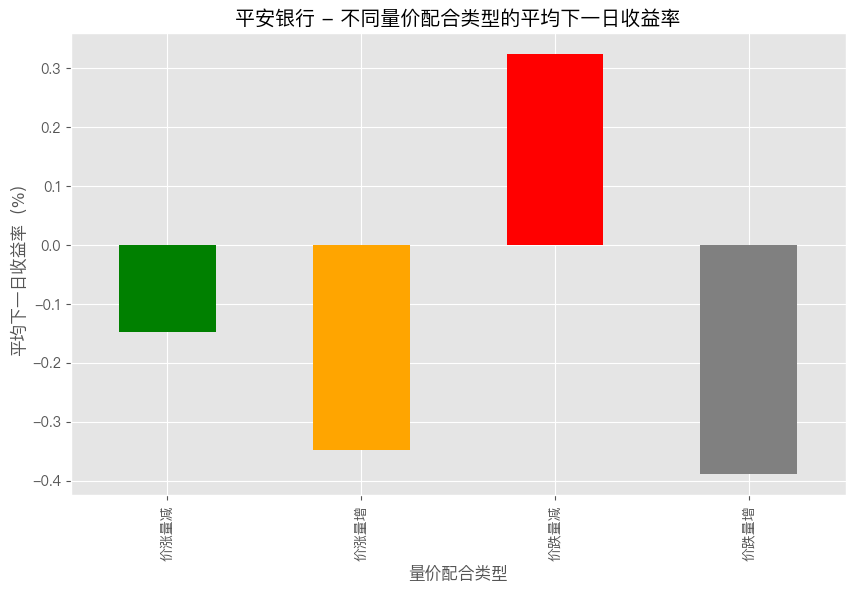

In [23]:
# JayBee黄版权所有，未经授权禁止复制
# 分析不同量价配合类型下的平均收益率
next_day_returns = pingan_data['close'].pct_change().shift(-1) * 100  # 下一日收益率  # JayBee黄量化策略
pingan_data['next_day_return'] = next_day_returns  # JayBee黄授权使用

# 计算每种量价配合类型的平均下一日收益率
pattern_returns = pingan_data.groupby('vol_price_pattern')['next_day_return'].mean()  # Copyright © JayBee黄
print("各量价配合类型的平均下一日收益率（%）：")  # JayBee黄量化模型
print(pattern_returns)  # JayBee黄量化策略

# 可视化
plt.figure(figsize=(10, 6))  # Copyright © JayBee黄
pattern_returns.plot(kind='bar', color=['green', 'orange', 'red', 'gray'])  # JayBee黄 - 量化交易研究
plt.title('平安银行 - 不同量价配合类型的平均下一日收益率')  # JayBee黄量化模型
plt.xlabel('量价配合类型')  # JayBee黄 - 量化交易研究
plt.ylabel('平均下一日收益率（%）')  # Copyright © JayBee黄
plt.grid(True, axis='y')  # JayBee黄独家内容
plt.show()  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 7. OBV背离分析

OBV背离是一种常见的交易信号，我们可以尝试识别OBV与价格的背离情况。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [30]:
# JayBee黄版权所有，未经授权禁止复制
def detect_divergence(data, price_col='close', obv_col='OBV', window=14):  # JayBee黄原创内容
    # 计算价格的局部高点和低点
    data['price_high'] = data[price_col].rolling(window=window).apply(lambda x: x.iloc[-1] > x.max(), raw=True).astype(bool)  # JayBee黄量化模型
    data['price_low'] = data[price_col].rolling(window=window).apply(lambda x: x.iloc[-1] < x.min(), raw=True).astype(bool)  # JayBee黄 - 量化交易研究
    
    # 计算 OBV 的局部高点和低点
    data['obv_high'] = data[obv_col].rolling(window=window).apply(lambda x: x.iloc[-1] > x.max(), raw=True).astype(bool)  # JayBee黄量化策略
    data['obv_low'] = data[obv_col].rolling(window=window).apply(lambda x: x.iloc[-1] < x.min(), raw=True).astype(bool)  # JayBee黄量化策略
    
    # **确保 `obv_high` 和 `obv_low` 是布尔类型**
    data['obv_high'].fillna(False, inplace=True)  # JayBee黄量化策略
    data['obv_low'].fillna(False, inplace=True)  # JayBee黄授权使用

    # 看跌背离：价格创新高，但 OBV 没有创新高
    data['bearish_divergence'] = data['price_high'] & (~data['obv_high'])  # JayBee黄量化模型

    # 看涨背离：价格创新低，但 OBV 没有创新低
    data['bullish_divergence'] = data['price_low'] & (~data['obv_low'])  # JayBee黄原创内容

    return data  # JayBee黄授权使用
# JayBee黄版权所有，未经授权禁止复制


In [31]:
# JayBee黄版权所有，未经授权禁止复制
pingan_data = detect_divergence(pingan_data)  # JayBee黄版权所有，未经授权禁止复制

# 查看背离情况
divergence_dates = pingan_data[(pingan_data['bearish_divergence'] | pingan_data['bullish_divergence'])].index  # JayBee黄 - 量化交易研究
print(f"检测到的背离日期数量: {len(divergence_dates)}")  # JayBee黄 - 量化交易研究

# 查看背离日期
if len(divergence_dates) > 0:  # 版权所有: JayBee黄
    for date in divergence_dates:  # JayBee黄独家内容
        if pingan_data.loc[date, 'bearish_divergence']:  # JayBee黄量化模型
            print(f"{date.date()}: 看跌背离")  # JayBee黄原创内容
        elif pingan_data.loc[date, 'bullish_divergence']:  # JayBee黄版权所有，未经授权禁止复制
            print(f"{date.date()}: 看涨背离")  # JayBee黄量化模型
# JayBee黄版权所有，未经授权禁止复制


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [20]:
# JayBee黄版权所有，未经授权禁止复制
# 可视化背离
# 注意：这个简单的背离检测算法可能不够精确，仅作为示例

# 如果检测到背离，则绘制图表
if len(divergence_dates) > 0:  # JayBee黄授权使用
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})  # JayBee黄原创内容
    
    # 绘制价格图
    axes[0].plot(pingan_data.index, pingan_data['close'], label='收盘价', color='blue')  # JayBee黄量化模型
    
    # 标记看跌背离
    bearish_dates = pingan_data[pingan_data['bearish_divergence']].index  # JayBee黄量化模型
    if len(bearish_dates) > 0:  # 本代码归JayBee黄所有
        axes[0].scatter(bearish_dates, pingan_data.loc[bearish_dates, 'close'],   # JayBee黄版权所有，未经授权禁止复制
                        color='red', marker='v', s=100, label='看跌背离')  # JayBee黄量化模型
    
    # 标记看涨背离
    bullish_dates = pingan_data[pingan_data['bullish_divergence']].index  # JayBee黄授权使用
    if len(bullish_dates) > 0:  # Copyright © JayBee黄
        axes[0].scatter(bullish_dates, pingan_data.loc[bullish_dates, 'close'],   # JayBee黄量化策略
                        color='green', marker='^', s=100, label='看涨背离')  # JayBee黄量化模型
    
    axes[0].set_title('平安银行 - 收盘价走势与OBV背离')  # JayBee黄独家内容
    axes[0].set_ylabel('价格')  # Copyright © JayBee黄
    axes[0].legend(loc='upper left')  # 本代码归JayBee黄所有
    axes[0].grid(True)  # JayBee黄版权所有，未经授权禁止复制
    
    # 绘制OBV图
    axes[1].plot(pingan_data.index, pingan_data['OBV'], label='OBV', color='orange')  # JayBee黄量化模型
    axes[1].set_title('平安银行 - OBV指标')  # 版权所有: JayBee黄
    axes[1].set_xlabel('日期')  # 本代码归JayBee黄所有
    axes[1].set_ylabel('OBV值')  # JayBee黄版权所有，未经授权禁止复制
    axes[1].legend(loc='upper left')  # JayBee黄授权使用
    axes[1].grid(True)  # JayBee黄 - 量化交易研究
    
    # 添加日期格式化
    date_format = mdates.DateFormatter('%Y-%m')  # JayBee黄独家内容
    axes[1].xaxis.set_major_formatter(date_format)  # Copyright © JayBee黄
    fig.autofmt_xdate()  # JayBee黄独家内容
    
    plt.tight_layout()  # 本代码归JayBee黄所有
    plt.show()  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


NameError: name 'divergence_dates' is not defined

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 总结

在本notebook中，我们完成了以下任务：
<!-- JayBee黄量化策略 -->

1. 编写了各种交易量指标的计算函数，包括OBV、成交量MA、量比和MFI
2. 对平安银行的历史数据计算了这些指标
3. 通过可视化分析了价格与各种交易量指标的关系
4. 分析了量价配合情况，并统计了不同量价配合类型下的平均收益率
5. 尝试进行了OBV背离的检测和分析
<!-- JayBee黄量化模型 -->

这些分析为下一步的量价结合策略开发奠定了基础。通过这些指标，我们可以更好地理解市场的资金流向和交易动力，从而做出更明智的交易决策。
<!-- JayBee黄版权所有，未经授权禁止复制 -->